In [74]:
import numpy as np
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import sqrtm


# Classification

In [75]:
ambient_dimension = 128
avg_num = int(1e+0) # number of experiment average
noise_std = 0.5
sign_false_rate = 0.1
snr = 4

In [76]:
sample_num = 70


# Data generation model:
# 1. 1-sparse vector
true_theta = np.zeros([ambient_dimension, 1])
signal_position = [0]
for i in signal_position:
    true_theta[i] = 1

# 2. random gaussian
# true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
# true_theta /= LA.norm(true_theta)
# true_theta = true_theta.reshape(-1, 1)

# 3. dense signal with spikes
#true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_theta[i] = 0
#spike_strength = 10000
#true_theta[0] = np.sqrt(spike_strength) * LA.norm(true_theta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
smallest_eig = .6  # choose 1 if you want uniform spectrum
decay = smallest_eig ** (1 / ambient_dimension)
decay = .95
off_diag_factor = 0
for i in range(ambient_dimension):
    #Sigma[i, i] = decay ** abs(i) if i in signal_position else 0
    Sigma[i, i] = decay ** abs(i)
for i in range(0, ambient_dimension, 2):
    Sigma[i+1, i] = off_diag_factor * Sigma[i, i]
    Sigma[i, i+1] = off_diag_factor * Sigma[i, i]

# 3. bi-level spectrum
# Sigma = np.identity(ambient_dimension)
# for i in range(int(ambient_dimension / 2), ambient_dimension):
#     Sigma[i, i] = smallest_eig

# 4. random spectrum
# Sigma = np.random.random((ambient_dimension, ambient_dimension))
# Sigma = Sigma.dot(Sigma.T)

alpha = snr * noise_std ** 2 / (true_theta.T.dot(Sigma).dot(true_theta)[0][0])
Sigma *= alpha

#for i in signal_position:
#    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in range(20):
#    Sigma[i, i] = 1
#for i in range(20, ambient_dimension):
#    Sigma[i, i] = 0.2

#for i in range(ambient_dimension):
#    Sigma[i, i] = random.random()

In [77]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    reg = np.identity(d)
    reg2 = 0.3 / (1 - 0.3) * diag
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_het_ridge_est(X, y, ridge_list):
    d = X.shape[1]
    n = X.shape[0]
    reg = n * np.identity(d)
    for i in range(d):
        reg[i, i] *= ridge_list[i]
    S = LA.pinv(X.T.dot(X) + reg).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_mask_lse_est(X, y):
    Cov = X.T.dot(X)
    n = X.shape[0]
    cov = np.diag(np.diag(Cov)) / n
    cov = sqrtm(cov)
    cov = LA.inv(cov)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = cov.dot(LA.pinv(cov.dot(Cov).dot(cov))).dot(cov).dot(X.T)
    return S.dot(y)

def get_lse_est_2(X, y):
    Cov = X.T.dot(X)
    mu = X.mean(axis=0).reshape(-1, 1)
    n = X.shape[0]
    #Z1 = n * mu.dot(mu.T)
    Z1 = Cov - 0.5 * np.diag(np.diag(Cov))
    A1 = np.concatenate((Cov, Z1), axis=1)
    A2 = np.concatenate((Z1.T, Cov), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    #B = np.concatenate((X.T, mu.dot(np.ones([1, n]))), axis=0).dot(y)
    B = np.concatenate((X.T, X.T), axis=0).dot(y)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    return LA.pinv(Z).dot(B)

def get_knockoff_est(X, y, D):
    Cov = X.T.dot(X)
    A = Cov.dot(np.identity(ambient_dimension) - LA.inv(Sigma).dot(D))
    A1 = np.concatenate((Cov, A), axis=1)
    B = 2 * D - D.dot(LA.inv(Sigma)).dot(D) + Cov - Cov.dot(LA.inv(Sigma)).dot(D) - D.dot(LA.inv(Sigma)).dot(Cov) + \
        D.dot(LA.inv(Sigma)).dot(Cov).dot(LA.inv(Sigma)).dot(D)
    A2 = np.concatenate((A.T, B), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    C = np.concatenate((np.identity(ambient_dimension), np.identity(ambient_dimension) - D.dot(LA.inv(Sigma))), axis=0)
    return LA.pinv(Z).dot(C).dot(X.T).dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    diag = np.diag(np.diag(Cov))
    #reg = np.trace(Cov) * np.identity(ambient_dimension) - Cov
    #Z = Cov + reg / ambient_dimension * 8 * p
    Z = Cov + p / (1 - p) * diag # + 0.41 * n * np.identity(ambient_dimension)
    S = LA.inv(Z).dot(X.T)
    # biased
    #return S.dot(y) / (1- p)
    # unbiased
    return S.dot(y)

def get_crop_est_bar(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = Cov + p / (1 - p) * n * Sigma
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_rotation_est(X, y, angle):
    angle = angle * np.pi /180
    Cov = X.T.dot(X)
    n = X.shape[0]
    diag = np.diag(np.diag(Cov))
    reg = np.trace(Cov) * np.identity(ambient_dimension) - Cov
    Z = Cov + reg / ambient_dimension * 4 * (1- np.cos(angle))
    #Z = Cov + p / (1 - p) * diag # + 0.41 * n * np.identity(ambient_dimension)
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

# heterogeneous mask
def get_het_crop_est(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    p1 = p / het_ratio
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    n = X.shape[0]
    p1 = p / het_ratio
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_risk(a, b):
    diff = a - b
    return  diff.T.dot(Sigma).dot(diff)[0, 0]

def get_risk_cls(su, cn):
    return  0.5 - np.arctan(su/cn) / np.pi

def get_norm(theta):
    return  theta.T.dot(Sigma).dot(theta)[0, 0]

def get_su(theta):
    pos = signal_position[0]
    return theta[pos,0] * np.sqrt(Sigma[pos,pos])

def get_cn(theta):
    pos = signal_position[0]
    return np.sqrt(theta.T.dot(Sigma).dot(theta)[0, 0] - (theta[pos,0] * np.sqrt(Sigma[pos,pos]))**2)

In [78]:
# Choose the type of augmentation:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
#ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-10, -6, num=0)), np.power(2, np.linspace(-5, 2, num=10)), np.power(2, np.linspace(2, 20, num=0))))
ridge_params = np.concatenate((np.linspace(0.01, 2, 10), np.linspace(2.1, 10, 10), np.linspace(11, 100, 5) ))
ridge_params = np.power(2, np.linspace(-10, 10, 20))
for i in range(len(ridge_params)):
    ridge_params[i] = ridge_params[i] ** 2
#crop_params = np.concatenate((np.power(2, np.linspace(-10, -5, num=10)), np.linspace(0.01, 0.4, num=10), np.linspace(.5, .99, num=10)))
crop_params = np.linspace(0.001, 0.99, 20)
rot_params = np.linspace(5, 180, 20)

#ridge_params = [1]
#crop_params = [0.3]
#pepper_params = {"ridge": [1], "drop_prob": [0.3]}

In [79]:
risk_lse = np.zeros([avg_num])
su_lse = np.zeros([avg_num])
cn_lse = np.zeros([avg_num])

risk_lse_mask = np.zeros([avg_num])
su_lse_mask = np.zeros([avg_num])
cn_lse_mask = np.zeros([avg_num])

risk_ridge = np.zeros([avg_num, len(ridge_params)])
su_ridge = np.zeros([avg_num, len(ridge_params)])
cn_ridge = np.zeros([avg_num, len(ridge_params)])

risk_crop = np.zeros([avg_num, len(crop_params)])
su_crop = np.zeros([avg_num, len(crop_params)])
cn_crop = np.zeros([avg_num, len(crop_params)])
#err_crop = np.zeros([avg_num, len(crop_params)])

risk_rot = np.zeros([avg_num, len(rot_params)])
su_rot = np.zeros([avg_num, len(rot_params)])
cn_rot = np.zeros([avg_num, len(rot_params)])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X_tr = np.zeros([sample_num, ambient_dimension])
    y_tr = np.zeros([sample_num, 1])
    for j in range(X_tr.shape[0]):
        X_tr[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        y_tr[j, :] = np.sign(np.inner(true_theta.reshape(-1), X_tr[j, :]))
        if random.uniform(0, 1) < sign_false_rate:
            y_tr[j, :] *= -1

    theta_lse = get_lse_est(X_tr, y_tr)
    su_lse[i] = get_su(theta_lse)
    cn_lse[i] = get_cn(theta_lse)
    risk_lse[i] = get_risk_cls(su_lse[i], cn_lse[i])

    theta_lse_mask = get_mask_lse_est(X_tr, y_tr)
    su_lse_mask[i] = get_su(theta_lse_mask)
    cn_lse_mask[i] = get_cn(theta_lse_mask)
    risk_lse_mask[i] = get_risk_cls(su_lse_mask[i], cn_lse_mask[i])


    # get loss
    for j in range(len(ridge_params)):
        theta = get_ridge_est(X_tr, y_tr, ridge_params[j])
        su_ridge[i, j] = get_su(theta)
        cn_ridge[i, j] = get_cn(theta)
        risk_ridge[i, j] = get_risk_cls(su_ridge[i, j], cn_ridge[i, j])
    for j in range(len(crop_params)):
        theta = get_crop_est(X_tr, y_tr, crop_params[j])
        su_crop[i, j] = get_su(theta)
        cn_crop[i, j] = get_cn(theta)
        risk_crop[i, j] = get_risk_cls(su_crop[i, j], cn_crop[i, j])

    for j in range(len(rot_params)):
        theta = get_rotation_est(X_tr, y_tr, rot_params[j])
        su_rot[i, j] = get_su(theta)
        cn_rot[i, j] = get_cn(theta)
        risk_rot[i, j] = get_risk_cls(su_rot[i, j], cn_rot[i, j])

risk_ridge = np.mean(risk_ridge, axis=0)
su_ridge = np.mean(su_ridge, axis=0)
cn_ridge = np.mean(cn_ridge, axis=0)
risk_crop = np.mean(risk_crop, axis=0)
su_crop = np.mean(su_crop, axis=0)
cn_crop = np.mean(cn_crop, axis=0)
risk_rot = np.mean(risk_rot, axis=0)
su_rot = np.mean(su_rot, axis=0)
cn_rot = np.mean(cn_rot, axis=0)

risk_lse = np.mean(risk_lse, axis=0)
su_lse = np.mean(su_lse, axis=0)
cn_lse = np.mean(cn_lse, axis=0)
risk_lse_mask = np.mean(risk_lse_mask, axis=0)
su_lse_mask = np.mean(su_lse_mask, axis=0)
cn_lse_mask = np.mean(cn_lse_mask, axis=0)



#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Complete in 1.14 sec


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0.5, 1.0, 'Random Mask ($\\beta$)')

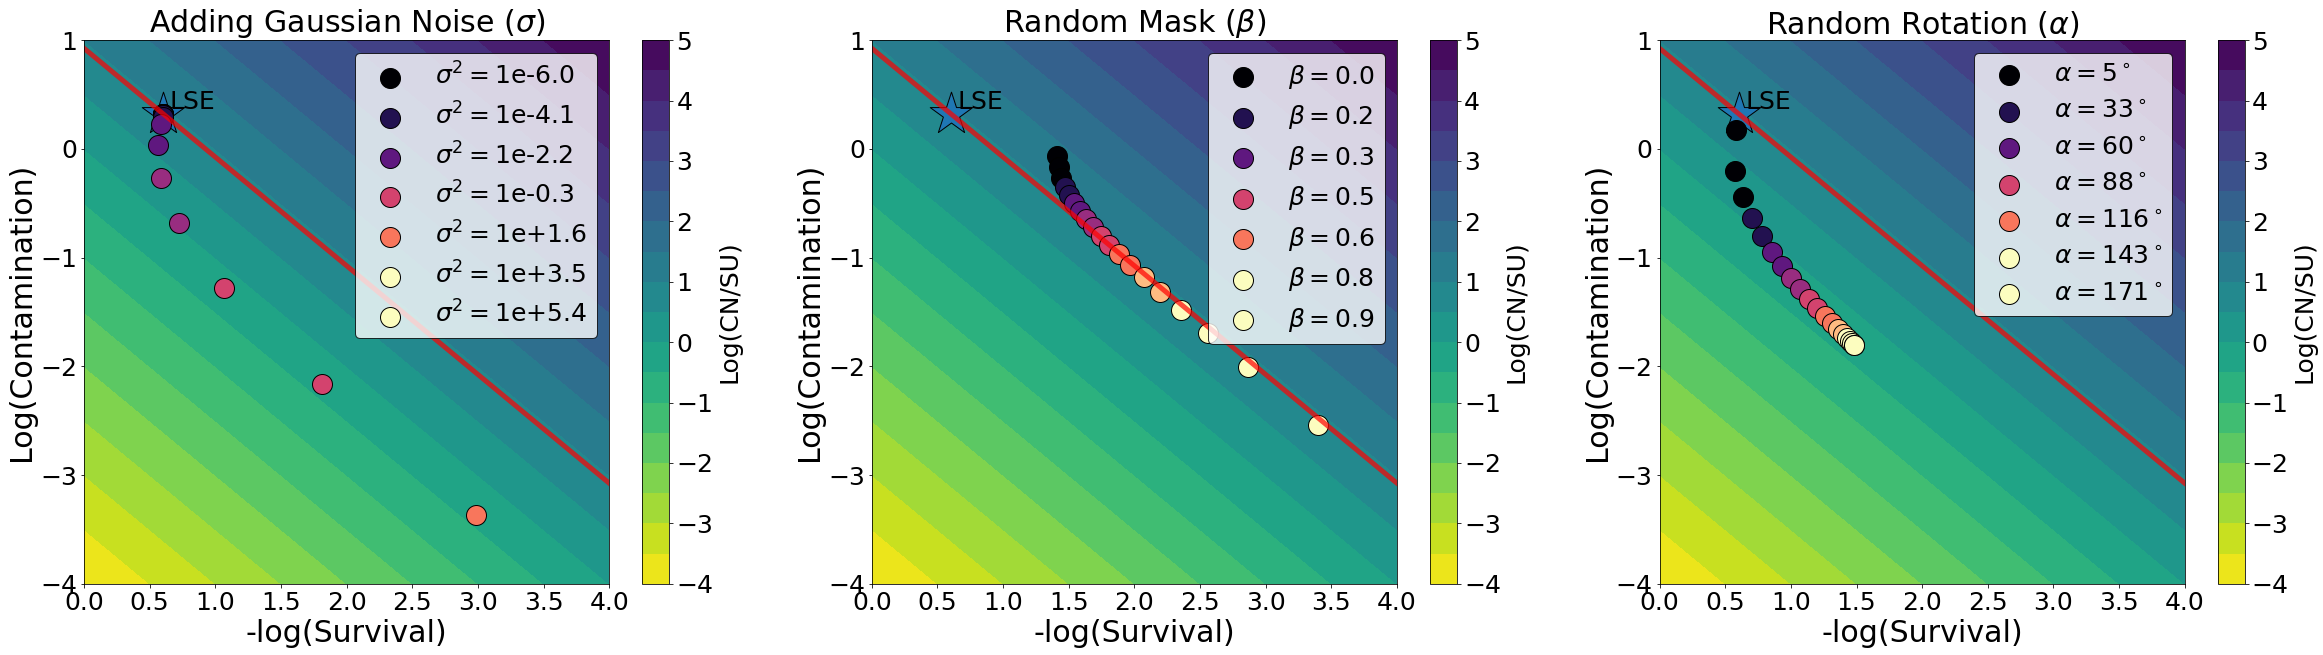

In [81]:
from matplotlib import cm

linewidth = 2.0
tick_size = 20
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap('viridis', 8)
plasma = cm.get_cmap('plasma', 8)
lse_color = viridis(-100)
y_min, y_max = 0.2, 1
markersize = 8
size_factor = 100

def mse(x, y):
    return x + y
def poe(x, y):
    return 0.5 - np.arctan(x / y) / np.pi
def minus(x, y):
    return  y - x

color1 = 'magma'
color2 = 'viridis_r'
color3 = 'plasma'
linewidth = 2.0
tick_size = 25
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap(color1, 8)
plasma = cm.get_cmap(color1, 8)
lse_color = viridis(-100)
legendsize = 25
x_min, x_max = -4, 0
y_min, y_max = -4, 1
X, Y = np.meshgrid(np.linspace(-x_max, -x_min), np.linspace(y_min, y_max))
Z = mse(X, Y)
position = "upper right"
# plt.contourf(X, Y, Z, 20, cmap='viridis')
# plt.colorbar()
# markersize = 8


size_factor = 100

plt.figure(figsize=(40, 10))
ax = plt.subplot(1, 3, 1)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Log(CN/SU)', fontsize=25)
plt.scatter(-np.log(su_lse), np.log(cn_lse), s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(-np.log(su_lse) + 0.05, np.log(cn_lse) + 0.05, s='LSE', fontsize=25, c='k')
# plt.scatter(-np.log(su_lse_mask), np.log(cn_lse_mask), s=1000, marker='*', facecolors='none', edgecolors='black', linewidths=4)
# plt.text(-np.log(su_lse_mask) + 0.1, np.log(cn_lse_mask) - 0.1, s='M-LSE', fontsize=25)
size_vec = ridge_params
for i in range(len(size_vec)):
    c = ''
    if round(np.log10(ridge_params[i]),2) >= 0:
        c = '+'
    lab = ""
    if i % 3 == 0:
        lab = r'$\sigma^2=$'+'1e'+c+format(round(np.log10(ridge_params[i]),2), '.1f')
    #plt.scatter(-np.log(su_ridge[i]), np.log(cn_ridge[i]), c=viridis(i/len(ridge_params)*1.2), s=3000 * np.sqrt(size_vec[i]))
    plt.scatter(-np.log(su_ridge[i]), np.log(cn_ridge[i]), c=viridis(i/len(ridge_params)*1.2), s=400, edgecolors='k', label=lab)
    # if 25 >= i >= 20:
    #     plt.text(-np.log(su_ridge[i]), np.log(cn_ridge[i]), s=format(np.sign(ridge_params[i]) * round(np.sqrt(np.abs(ridge_params[i])),3), '.2f'), fontsize=22, rotation=40, color="red")
leg = plt.legend(loc=position, prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-np.log(su_lse) + np.log(cn_lse) - 1, 4 ], [1, (-np.log(su_lse) + np.log(cn_lse))-4], linestyle='-', linewidth=5, alpha=0.7, color='red')
plt.xlabel('-log(Survival)', fontsize=30)
plt.ylabel('Log(Contamination)', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-x_max, -x_min)
plt.ylim(y_min, y_max)
plt.title('Adding Gaussian Noise '+r'($\sigma$)', fontsize=30)

ax = plt.subplot(1, 3, 3)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Log(CN/SU)', fontsize=25)
plt.scatter(-np.log(su_lse), np.log(cn_lse), s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(-np.log(su_lse) + 0.05, np.log(cn_lse) + 0.05, s='LSE', fontsize=25, c='k')
# plt.scatter(-np.log(su_lse_mask), np.log(cn_lse_mask), s=1000, marker='*', facecolors='none', edgecolors='black', linewidths=4)
# plt.text(-np.log(su_lse_mask) + 0.1, np.log(cn_lse_mask) - 0.1, s='M-LSE', fontsize=25)
size_vec = rot_params
for i in range(len(rot_params)):
    #plt.scatter(-np.log(su_rot[i]), np.log(cn_rot[i]), c=viridis(i/len(rot_params)*1.2), s=5*(size_vec[i]))
    lab = ""
    if i % 3 == 0:
        lab = r'$\alpha=$' + format(round(rot_params[i],3), '.0f')+r'$^\circ$'
    plt.scatter(-np.log(su_rot[i]), np.log(cn_rot[i]), c=viridis(i/len(rot_params)*1.2), s=400, edgecolors='k', label=lab)
    # if (i % 2 ==0 ):
    #     plt.text(-np.log(su_rot[i])+0.02, np.log(cn_rot[i])+0.02, s=format(round(rot_params[i])), fontsize=22, rotation=40, color="red")
leg = plt.legend(loc=position, prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-np.log(su_lse) + np.log(cn_lse) - 1, 4 ], [1, (-np.log(su_lse) + np.log(cn_lse))-4], linestyle='-', linewidth=5, alpha=0.7, color='red')
plt.xlabel('-log(Survival)', fontsize=30)
plt.ylabel('Log(Contamination)', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-x_max, -x_min)
plt.ylim(y_min, y_max)
plt.title('Random Rotation '+r'($\alpha$)', fontsize=30)

ax = plt.subplot(1, 3, 2)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Log(CN/SU)', fontsize=25)
plt.scatter(-np.log(su_lse), np.log(cn_lse), s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(-np.log(su_lse) + 0.05, np.log(cn_lse) + 0.05, s='LSE', fontsize=25, c='k')
# plt.scatter(-np.log(su_lse_mask), np.log(cn_lse_mask), s=1000, marker='*', facecolors='none', edgecolors='black', linewidths=4)
# plt.text(-np.log(su_lse_mask) + 0.1, np.log(cn_lse_mask) + 0.2, s='M-LSE', fontsize=25)
size_vec = crop_params
for i in range(len(size_vec)):
    lab = ""
    if i % 3 == 0:
        lab = r'$\beta=$' + format(round(crop_params[i],3), '.1f')
    #plt.scatter(-np.log(su_crop[i]), np.log(cn_crop[i]), c=viridis(i/len(crop_params)*1.2), s=500*(size_vec[i]))
    plt.scatter(-np.log(su_crop[i]), np.log(cn_crop[i]), c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k', label=lab)
    # if (i <= 6 and i % 3 == 0) or (i > 6 and i % 3 == 0):
    #     plt.text(-np.log(su_crop[i]), np.log(cn_crop[i]), s=format(round(crop_params[i],3), '.2f'), fontsize=22, rotation=40, color="red")
leg = plt.legend(loc=position, prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-np.log(su_lse) + np.log(cn_lse) - 1, 4 ], [1, (-np.log(su_lse) + np.log(cn_lse))-4], linestyle='-', linewidth=5, alpha=0.7, color='red')
plt.xlabel('-log(Survival)', fontsize=30)
plt.ylabel('Log(Contamination)', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-x_max, -x_min)
plt.ylim(y_min, y_max)
plt.title('Random Mask '+r'($\beta$)', fontsize=30)